In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%load_ext autoreload
%autoreload 2

In [2]:
from common_functions import latexify, format_axes, tableau20blind
latexify(14, 8)

In [3]:
def foo(lastKDays):
    dfs = []
    splits = 6
    for i in range(splits):
        for j in range(splits-1):
            gp = np.load(f"../exp2/src/results/{lastKDays}/final_gp/{i}_{j}/final_rmse.npy")
            qbc = np.load(f"../exp2/src/results/{lastKDays}/final_qbc/{i}_{j}/final_rmse.npy")
            qbc_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_qbc/{i}_{j}/final_rmse.npy")
            gp_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_gp/{i}_{j}/final_rmse.npy")
            gp = gp[: len(gp) - 7]
            qbc = qbc[: len(qbc) - 7]
            qbc_rd = qbc_rd[:, :qbc_rd.shape[1] - 7]
            gp_rd = gp_rd[:, :gp_rd.shape[1] - 7]
            
            for reg, temp in zip(["gp", "qbc"], [gp, qbc]):
                temp1 = temp[~np.isnan(temp)]
                days = np.array([i for i in range(temp.shape[0])])
                store = {
                    'kout': [i]*temp1.shape[0],
                    'kin': [j]*temp1.shape[0],
                    'reg': [reg] * temp1.shape[0],
                    "day": list(days[~np.isnan(temp)]),
                    "rmse": temp1,
                    "lastKDays": [lastKDays]*temp1.shape[0],
                    "seed": [-1]*temp1.shape[0]
                }
                tempdf = pd.DataFrame(store)
                dfs.append(tempdf)
            for reg, temp in zip(["qbc_rd", "gp_rd"], [qbc_rd, gp_rd]):
                for seed in range(5):
                    temp1 = temp[seed, :]
                    temp2 = temp1[~np.isnan(temp1)]
                    days = np.array([i for i in range(temp1.shape[0])])
                    store = {
                        'kout': [i] * temp2.shape[0],
                        'kin': [j] * temp2.shape[0],
                        'reg': [reg] * temp2.shape[0],
                        "day": list(days[~np.isnan(temp1)]),
                        "rmse": temp2,
                        "lastKDays": [lastKDays]*temp2.shape[0],
                        "seed": [seed]*temp2.shape[0]
                    }
    #                 print ([len(k) for k in store.values()])
                    tempdf = pd.DataFrame(store)
                    dfs.append(tempdf)
                
    return pd.concat(dfs)

In [4]:
df = foo(30)
df.groupby('reg').get_group("qbc_rd")

,kout,kin,reg,day,rmse,lastKDays,seed
0,0,0,qbc_rd,0,40.630352,30,0
1,0,0,qbc_rd,1,20.570024,30,0
2,0,0,qbc_rd,2,12.889022,30,0
3,0,0,qbc_rd,3,15.272736,30,0
4,0,0,qbc_rd,4,23.753830,30,0
...,...,...,...,...,...,...,...
324,5,4,qbc_rd,324,43.556384,30,4
325,5,4,qbc_rd,325,30.414939,30,4
326,5,4,qbc_rd,326,21.958475,30,4
327,5,4,qbc_rd,327,42.921699,30,4


In [5]:
splits = 6
dic = {}
for lastKDays in [30]:
    tdic = {}
    df = foo(lastKDays)
    days = df['day'].unique()
    for ix, tempdf in df.groupby(["kout", "kin"]):
        for reg_comp in ["qbc", "qbc_rd", "gp_rd"]:
            comp = reg_comp
#             try:
            a =  tempdf[tempdf["reg"] == 'gp']["rmse"].values
            if sum(np.isnan(a)) != 0:
                raise ValueError
            b = tempdf[tempdf["reg"] == reg_comp]["rmse"].values
#             print (b)
            if sum(np.isnan(b)) != 0:
                raise ValueError
            a = a.mean()
            b = b.mean()
            if a <= b:
                temp = tdic.get(comp, [0, 0])
                tdic[comp] = [temp[0] + 1, temp[1]]
            else:
                temp = tdic.get(comp, [0, 0])
                tdic[comp] = [temp[0], temp[1] + 1]
#             except Exception as e:
#                 print (e)
#                 continue
    print ("lastKDays Done: ", lastKDays)
    dic[f"lastKDays_{lastKDays}"] = tdic

lastKDays Done:  30


In [6]:
dic

{'lastKDays_30': {'qbc': [30, 0], 'qbc_rd': [30, 0], 'gp_rd': [24, 6]}}

In [7]:
new_dic = {
    'lastKDays': [],
    'qbc': [],
    'qbc_rd': [],
    'gp_rd': [],
}
for ls, di in dic.items():
    new_dic['lastKDays'].append(ls)
    new_dic['qbc'].append(tuple(di['qbc']))
    new_dic['qbc_rd'].append(tuple(di['qbc_rd']))
    new_dic['gp_rd'].append(tuple(di['gp_rd']))

In [8]:
win_loss = pd.DataFrame(new_dic)
win_loss

,lastKDays,qbc,qbc_rd,gp_rd
0,lastKDays_30,"(30, 0)","(30, 0)","(24, 6)"


In [9]:
foo(10).head()

,kout,kin,reg,day,rmse,lastKDays,seed
0,0,0,gp,0,4.098668,10,-1
1,0,0,gp,1,6.443400,10,-1
2,0,0,gp,2,5.249915,10,-1
3,0,0,gp,3,4.046290,10,-1
4,0,0,gp,4,6.314935,10,-1


In [10]:
dic = {
    "lastKDays": [] ,
    "best_ix": [] ,
    "worst_ix": [] ,
    "comp": [],
}
try:
    win_loss_plots = pd.read_csv("win_loss_plots.csv")
except:
    raise ValueError
    for comp in ["qbc", "qbc_rd", "gp_rd"]:
        splits = 6
        import sys
        max_err = sys.maxsize
        min_err = - sys.maxsize
        for lastKDays in [30]:
            tdic = {}
            df = foo(lastKDays)
            days = df['day'].unique()
            best_ratio = 0
            worst_ratio = 1
            best_ix = None
            worst_ix = None
            for ix, tempdf in df.groupby(["kout", "kin"]):
                gp_win = 0
                gp_loose = 0
                for jx, tempdf1 in tempdf.groupby("day"):
                    a = tempdf1[tempdf1["reg"] == 'gp']["rmse"]
                    b = tempdf1[tempdf1["reg"] == comp]["rmse"]
                    if (a.shape[0] != 0 and b.shape[0] != 0):
                        a = a.mean()
                        b = b.mean()
                    else:
                        print (f"{jx}th Day did not have values for both")
                        continue

                    
                    if a <= b:
                        gp_win += 1
                    else:
                        gp_loose += 1

                win_ratio = float(gp_win)/(gp_loose + gp_win)
                if best_ratio < win_ratio:
                    best_ratio = win_ratio
                    best_ix = ix
                if worst_ratio > win_ratio:
                    worst_ratio = win_ratio
                    worst_ix = ix
            print (comp, "lastKDays Done: ", lastKDays)
            dic["lastKDays"].append(lastKDays)
            dic["best_ix"].append(best_ix)
            dic["worst_ix"].append(worst_ix)
            dic["comp"].append(comp)
            
    win_loss_plots = pd.DataFrame(dic)


In [11]:
win_loss_plots.to_csv("win_loss_plots.csv", index = None)
win_loss_plots["best_ix"].values
win_loss_plots

,lastKDays,best_ix,worst_ix,comp
0,30,"(2, 4)","(1, 1)",qbc
1,30,"(0, 2)","(1, 1)",qbc_rd
2,30,"(0, 3)","(0, 0)",gp_rd


In [12]:
params = {
    'lines.linewidth': 2,
    'lines.color': 'k',
#     'boxplot.boxprops.linewidth': 20,
    'boxplot.boxprops.color': 'k',
    'patch.linewidth': 3,
    'legend.fontsize': 14 + 4,
    'legend.framealpha': .6,
    'axes.titlesize': 14 + 4,
    "axes.labelsize": 14 + 4,
    'xtick.labelsize': 14 + 4,
    'ytick.labelsize': 16 + 4,
#     'axes.labelweight': 'bold',
    'axes.linewidth': 2,
#     'font.weight': 'bold'
    
}
matplotlib.rcParams.update(params)

In [30]:
lastPlotDay = 120

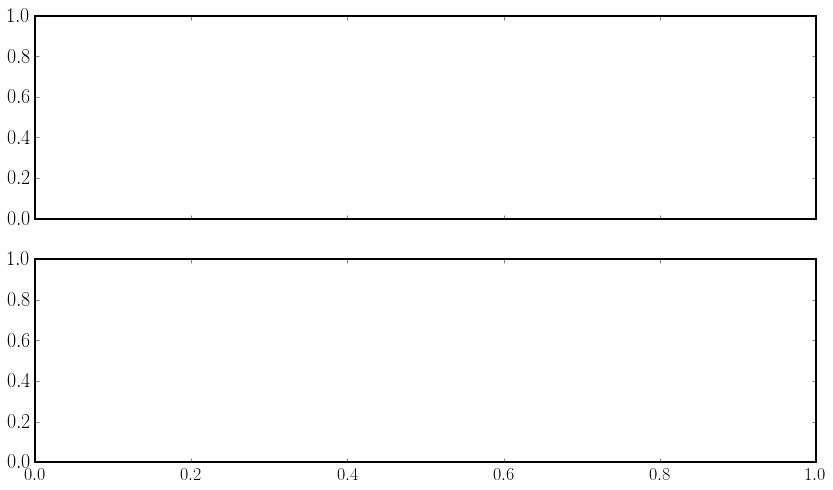

In [31]:
axs = plt.subplots(nrows=2, sharex=True);


(2, 4) (1, 1)


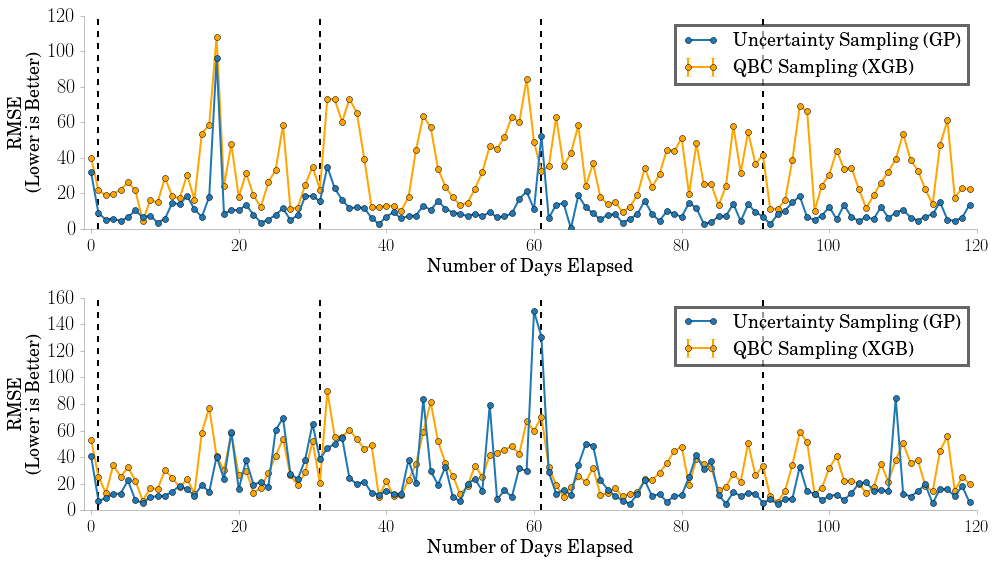

(0, 2) (1, 1)


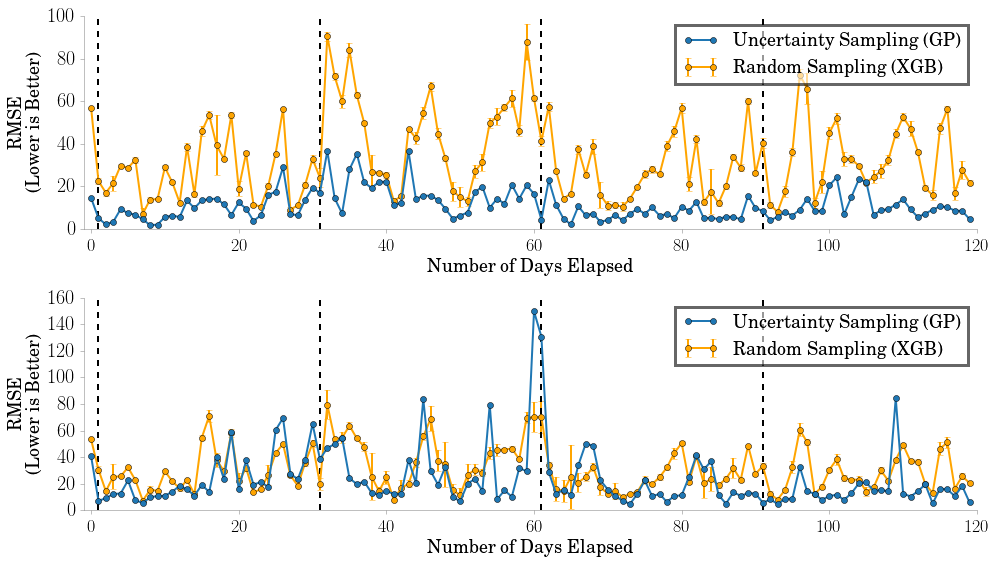

(0, 3) (0, 0)


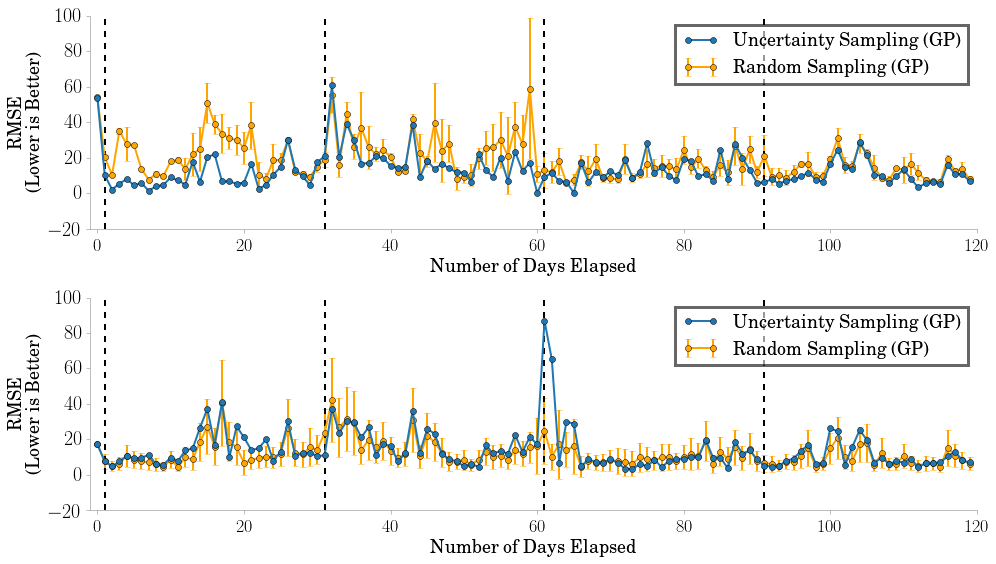

In [32]:

for scomp, comp in zip(["QBC Sampling (XGB)", "Random Sampling (XGB)", "Random Sampling (GP)"],
                       ["qbc", "qbc_rd", "gp_rd"]):
    for k, temp_df in win_loss_plots.groupby("lastKDays"):
        if k != 30:
            continue
        df = foo(k)
        hello = win_loss_plots[(win_loss_plots['comp']==comp) & (win_loss_plots['lastKDays']==k)]
        best_ix, worst_ix = hello[["best_ix", "worst_ix"]].values[0]
        best_ix = tuple(map(int, best_ix[1:-1].split(", ")))
        worst_ix = tuple(map(int, worst_ix[1:-1].split(", ")))
        print (best_ix, worst_ix)
        fig, axs = plt.subplots(nrows=2, sharex=True)
        for ax_num, some_ix, s in zip([0,1], [best_ix, worst_ix], ["Best", "Worst"]):
            yoyo_df = df[(df['kout'] == some_ix[0]) & (df['kin'] == some_ix[1])]# contains comp and gp
            
            gp_days = yoyo_df[yoyo_df["reg"] == 'gp']["day"].values
            gp_mean = []
            for gp_day in gp_days:
                rela = yoyo_df[(yoyo_df["reg"] == 'gp') & (yoyo_df["day"] == gp_day)]["rmse"]
                gp_mean.append(rela.mean())
#                 gp_mean.append(rela.mean())
                
            comp_days = yoyo_df[yoyo_df["reg"] == comp]["day"].unique()
            comp_mean = []
            comp_std = []
            for comp_day in comp_days:
                rela = yoyo_df[(yoyo_df["reg"] == comp) & (yoyo_df["day"] == comp_day)]["rmse"]
                comp_mean.append(rela.mean())
                comp_std.append(rela.std())
                
#             print (gp_days, gp_mean)
#             comp_mean = yoyo_df[(yoyo_df["reg"] == comp)]["rmse"].values
#             comp_std = yoyo_df[yoyo_df["reg"] == comp]["std"].values
#             gp_days = 
#             comp_days = 
#             print ('gp_mean', gp_mean)
#             print ('comp_mean', comp_mean)
#             print ('comp_std', comp_std)
            arr = [(d, m) for d, m in zip(gp_days, gp_mean)]
            arr.sort(key=lambda x:x[0])
        
            axs[ax_num].plot(
                [a[0] for a in arr][:lastPlotDay], 
                [a[1] for a in arr][:lastPlotDay],
                label="Uncertainty Sampling (GP)",
                marker="o",
                zorder=10
            )
            
            
            arr = [(d, m, s) for d, m, s in zip(comp_days, comp_mean, comp_std)]
            arr.sort(key=lambda x:x[0])
            
            axs[ax_num].errorbar(
                [a[0] for a in arr][:lastPlotDay], 
                [a[1] for a in arr][:lastPlotDay],
                yerr = [a[2] for a in arr][:lastPlotDay], 
                label=scomp,
                marker="o",
                c='orange',
            )
            
            for x in range(1, lastPlotDay, 30):
                axs[ax_num].axvline(
                    x=x, 
                    linestyle='--',
                )
    #         plt.errorbar(range(len(comp_std)), comp_std, c="orange")
#             plt.title(f"{s} for lastKDays = {k}")
            axs[ax_num].set_ylabel("RMSE\n(Lower is Better)")
            axs[ax_num].set_xlabel("Number of Days Elapsed")
            axs[ax_num].legend(loc="upper right").set_zorder(20)
            axs[ax_num].set_xlim(-1)
            format_axes(axs[ax_num])
        fig.tight_layout()
        plt.savefig(f"plts/{scomp}_{lastKDays}.pdf")
        plt.show()

In [22]:
arr

[(0, 17.15312733006046, 0.0),
 (0, 17.15312733006046, 0.0),
 (0, 17.15312733006046, 0.0),
 (0, 17.15312733006046, 0.0),
 (0, 17.15312733006046, 0.0),
 (1, 7.603714914264077, 4.380623169188424),
 (1, 7.603714914264077, 4.380623169188424),
 (1, 7.603714914264077, 4.380623169188424),
 (1, 7.603714914264077, 4.380623169188424),
 (1, 7.603714914264077, 4.380623169188424),
 (2, 5.028766952442281, 2.8783557488460128),
 (2, 5.028766952442281, 2.8783557488460128),
 (2, 5.028766952442281, 2.8783557488460128),
 (2, 5.028766952442281, 2.8783557488460128),
 (2, 5.028766952442281, 2.8783557488460128),
 (3, 6.364519696189954, 3.7082725732264574),
 (3, 6.364519696189954, 3.7082725732264574),
 (3, 6.364519696189954, 3.7082725732264574),
 (3, 6.364519696189954, 3.7082725732264574),
 (3, 6.364519696189954, 3.7082725732264574),
 (4, 10.818449858779077, 6.167487958282866),
 (4, 10.818449858779077, 6.167487958282866),
 (4, 10.818449858779077, 6.167487958282866),
 (4, 10.818449858779077, 6.167487958282866),


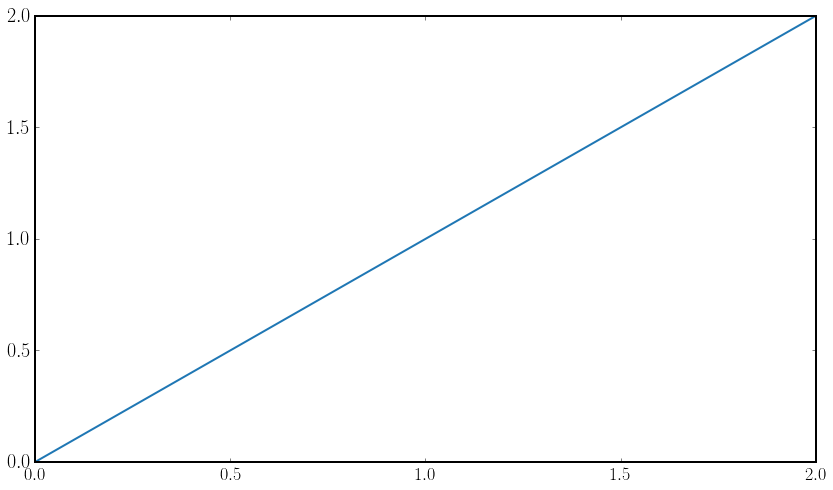

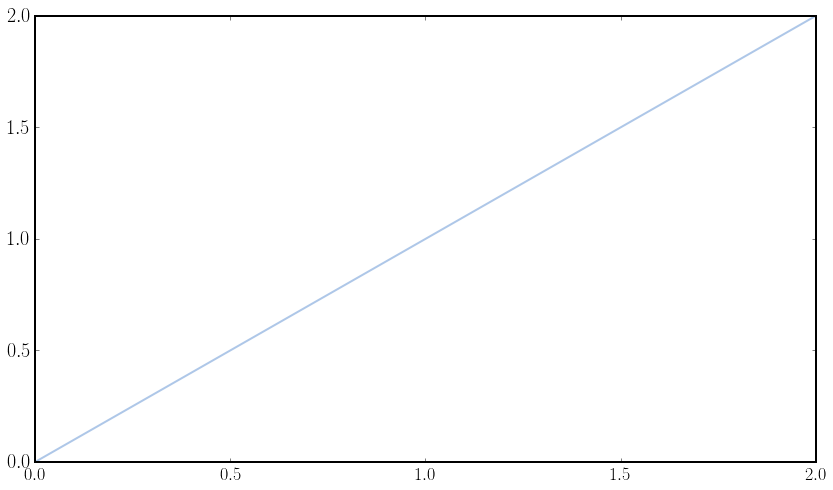

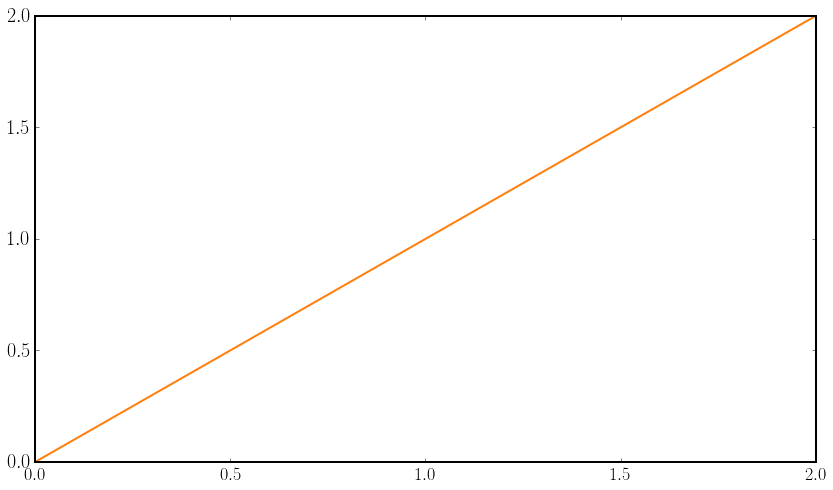

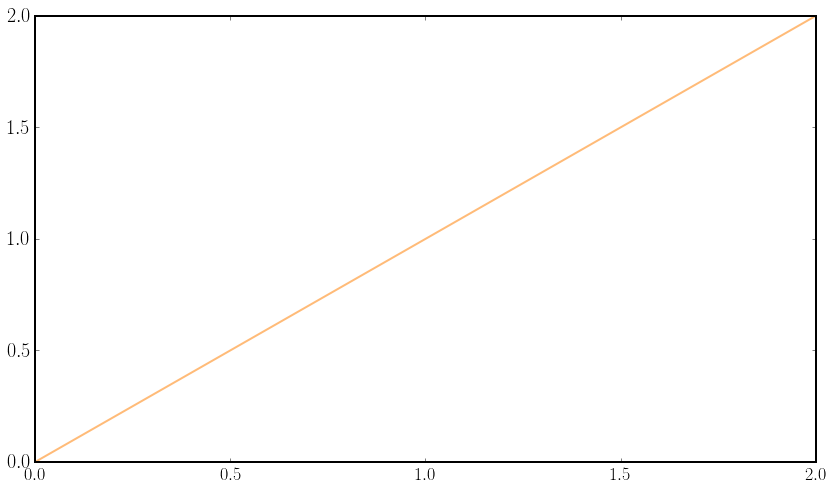

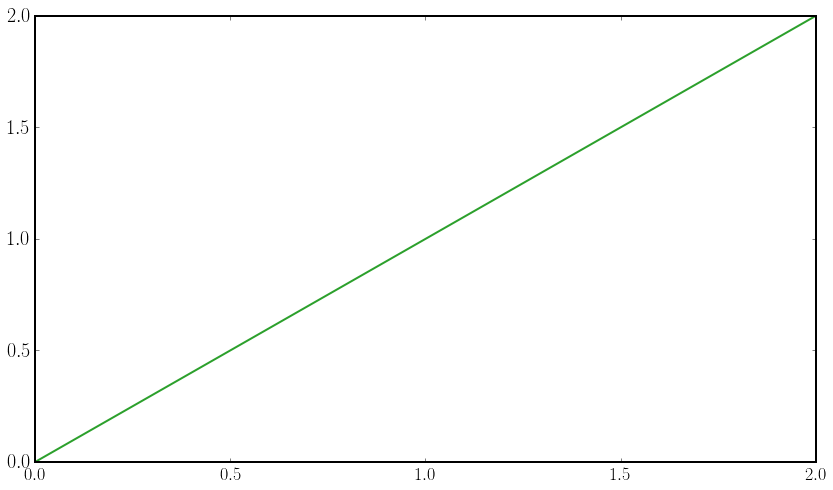

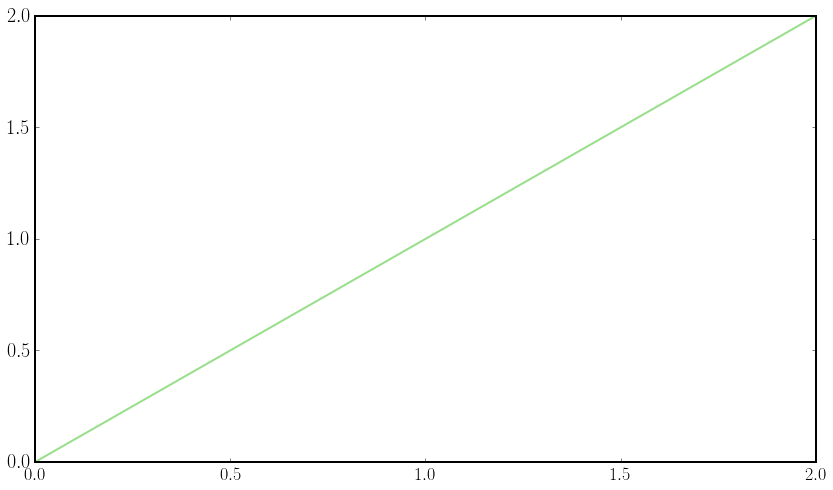

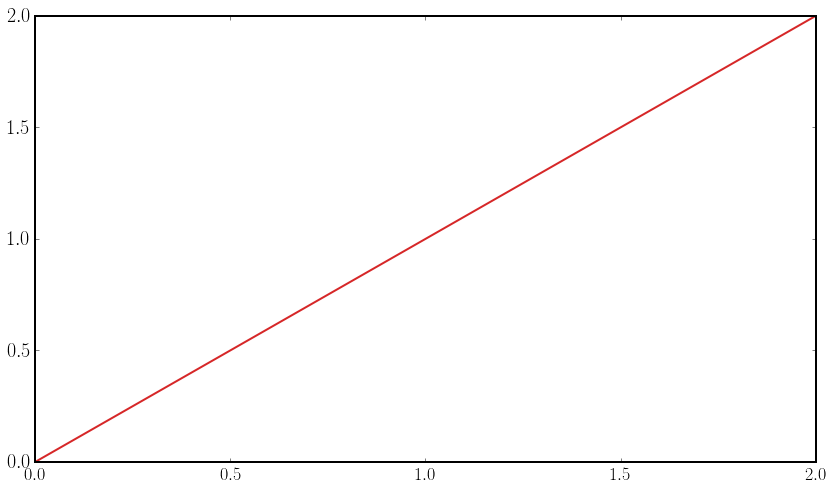

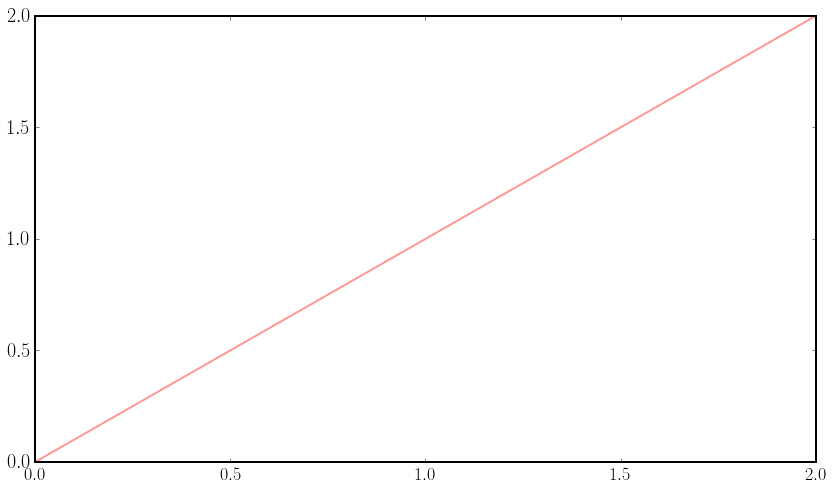

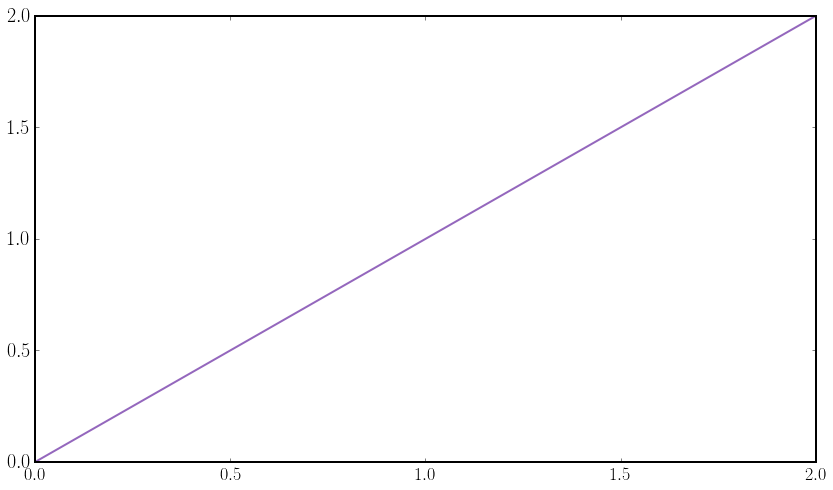

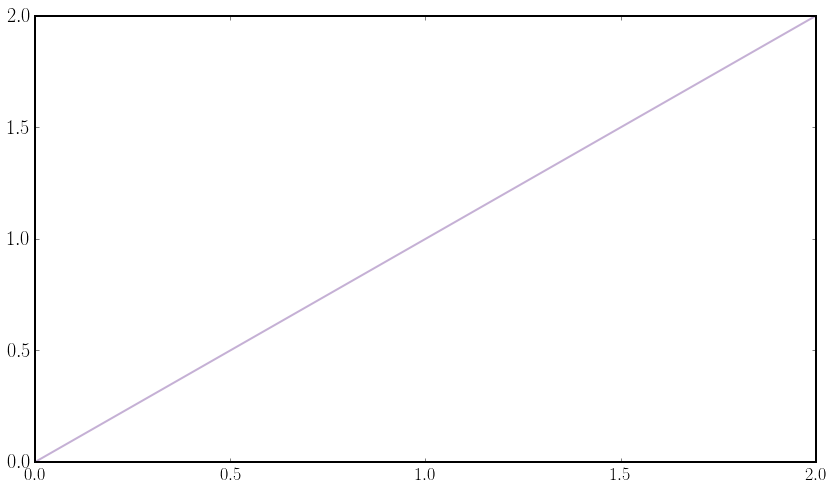

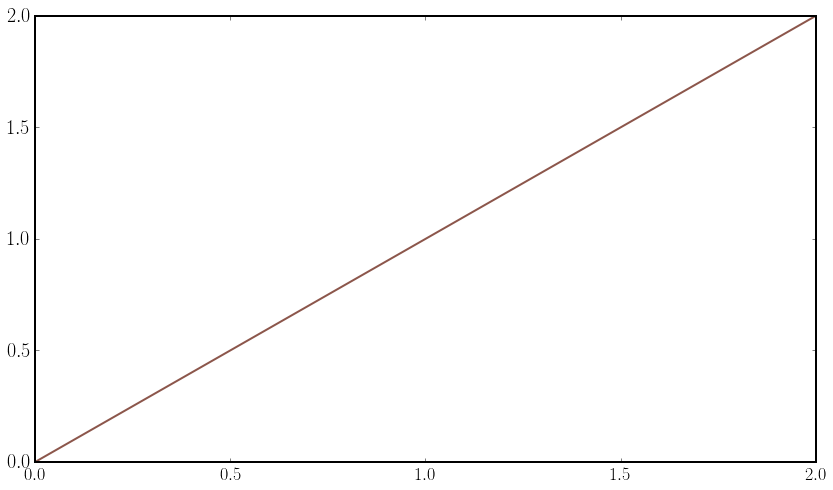

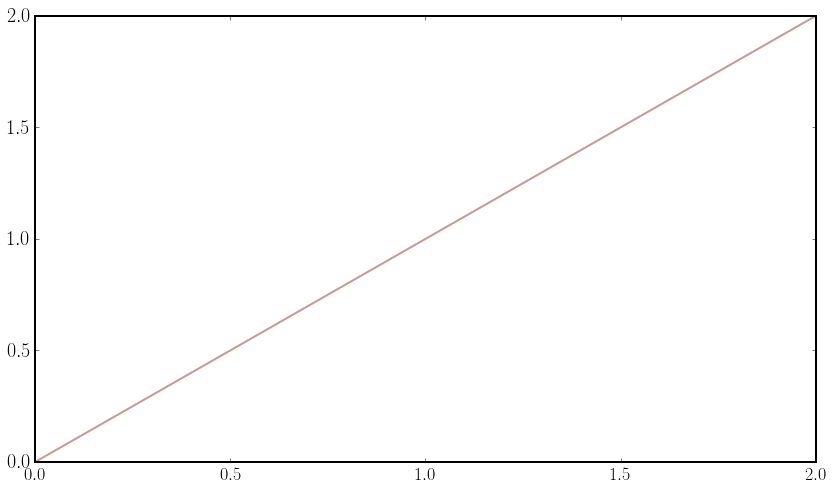

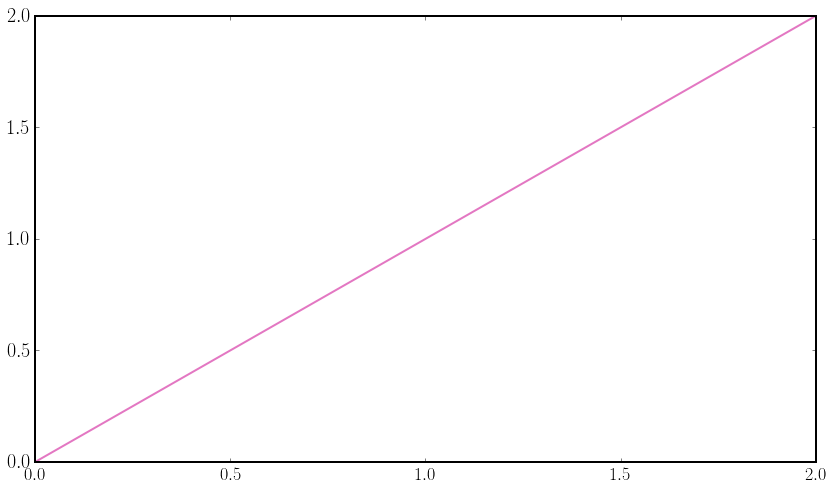

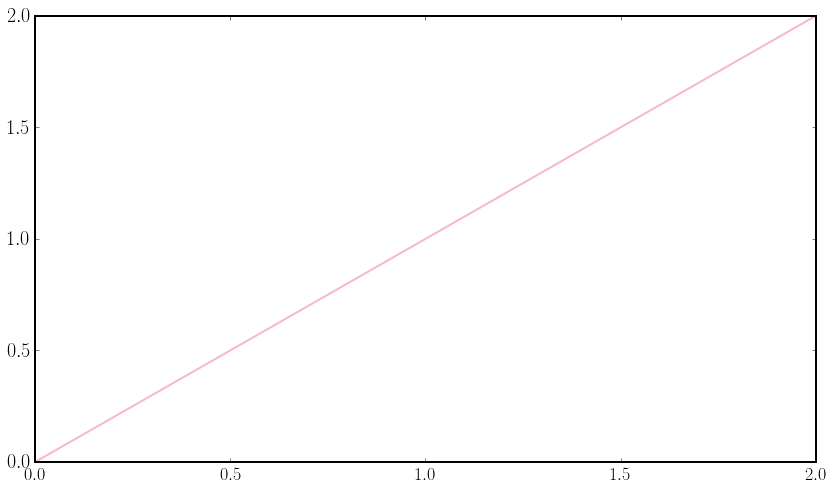

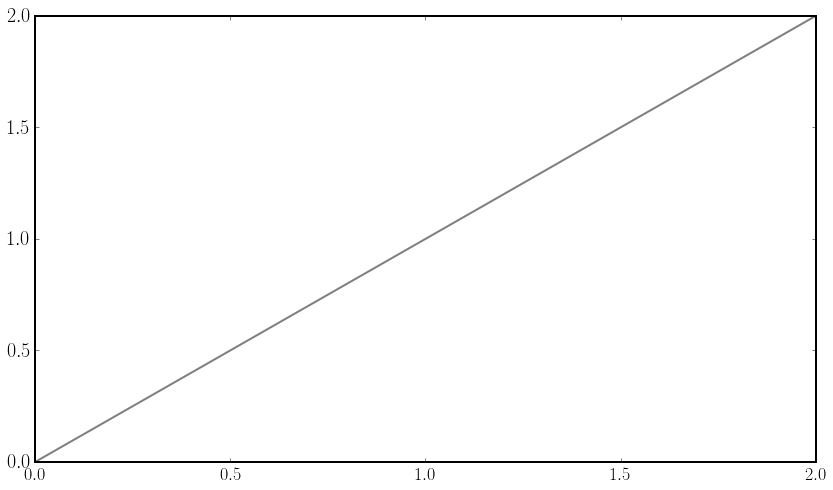

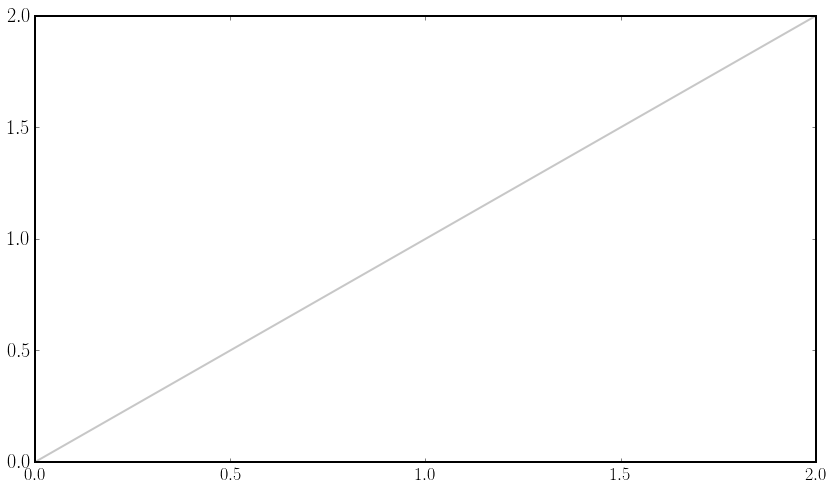

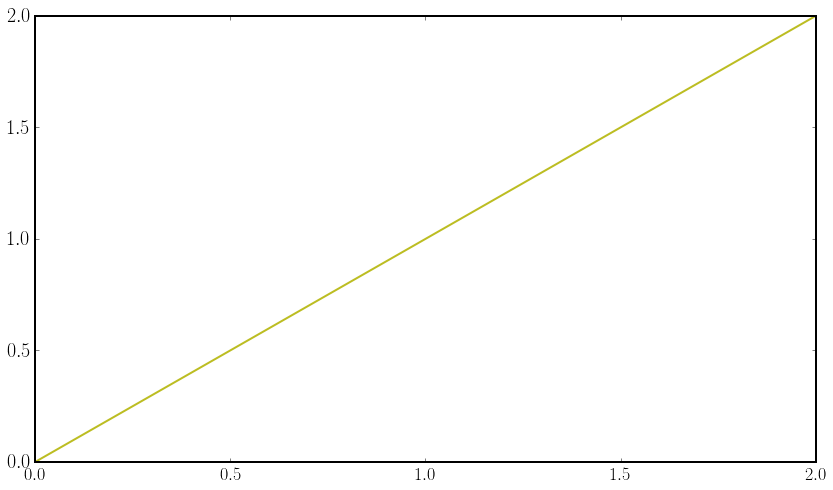

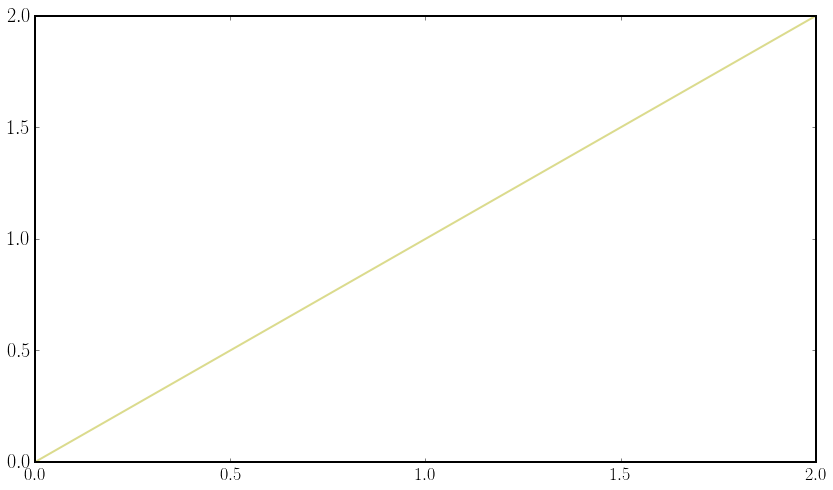

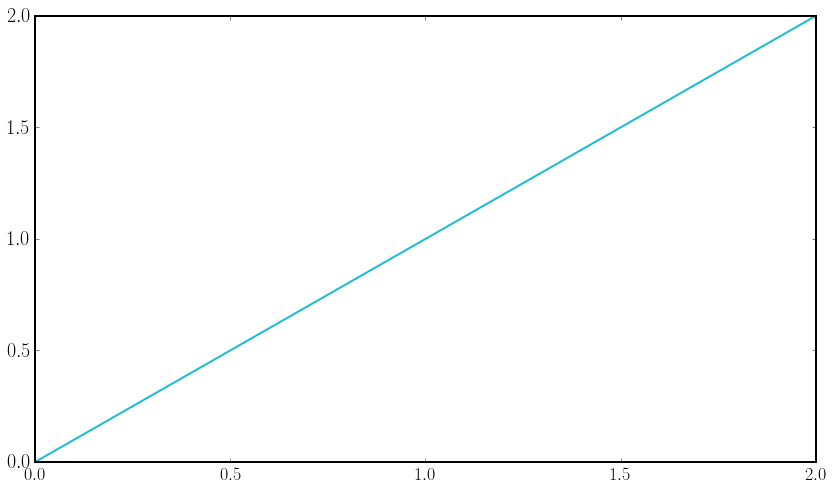

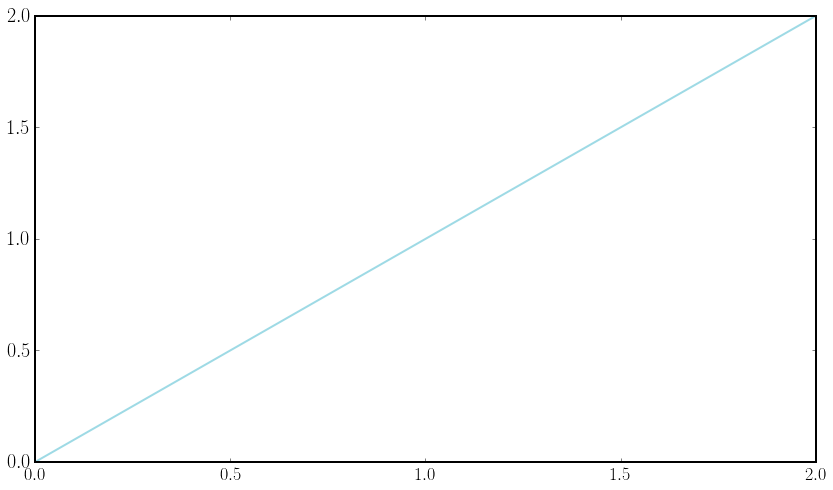

In [27]:
for i in range(len(tableau20blind)):
    plt.plot(range(3), range(3), c=tableau20blind[i])
    plt.show()